<a href="https://colab.research.google.com/github/drize11Six/Advertisement-System-With-Machine-Learning/blob/main/Ads_system_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building an advertisement system with machine learning.
In this project, we will build a machine learning model that provides personalized ads to customers simply by predicting the brand of product they are most likely to buy depending on their recent activities in the ecommerce store and their demographics.
Knowing that all machine learning algorithm works on numerical values, a particular numeric value will be assigned to each product brand and the model (machine learning algorithms + training data) will predict those numbers after undergoing training. This prediction will enable the system to display only the products from the predicted brand.



In [ ]:
# Importing the needed libraries
!pip install shap
!pip install colorama
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import plotly.express as px
import plotly.offline as po
import cufflinks as cl
plt.style.use('seaborn')
from colorama import Style, Fore, Back
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump
import shap
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

##Data Collection
The two dataset used was collected from [kaggle](https://www.kaggle.com/datasets). It is a collection of different users demographics and behaviour in an eCommerce store.

In [ ]:
#Loading the data
data = pd.read_csv("/content/drive/MyDrive/Datasets/ecommerce.csv")

In [ ]:
#Checking the number of rows and columns of the dataset
data.shape 

(47482, 12)

The dataset has 19 different features(columns) and 47482 observations(rows)

In [ ]:
#Reading the first five rows of the dataset
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,subcategory,is_purchased,event_weekday,activity_count,income,age,marriage_status,profession,country
0,2019-10-01 03:36:06 UTC,purchase,3900860,2053013552326770905,appliances.environment.water_heater,ariston,84.69,514732891,07e3eec5-10d5-481f-afd3-15f749071155,appliances|environment,water_heater,1.0,1,21.0,312.415297,23,single,Physician,South Korea
1,2019-10-01 04:07:44 UTC,purchase,3900815,2053013552326770905,appliances.environment.water_heater,ariston,133.82,515798665,5f184310-6754-48ce-a21b-df21aa81457e,appliances|environment,water_heater,1.0,1,4.0,1814.950879,40,single,Physician,USA
2,2019-10-01 04:43:16 UTC,purchase,3900702,2053013552326770905,appliances.environment.water_heater,thermex,115.75,518045212,fd66a737-84d6-4ca4-a2b5-85752270315f,appliances|environment,water_heater,1.0,1,3.0,956.489912,66,married,Physician,India
3,2019-10-01 05:07:47 UTC,purchase,3900002,2053013552326770905,appliances.environment.water_heater,ariston,103.18,514008577,3d57b23e-c071-4f84-a179-29b825d21aed,appliances|environment,water_heater,1.0,1,16.0,1499.125653,41,single,Physician,Mexico
4,2019-10-01 05:14:48 UTC,purchase,3900647,2053013552326770905,appliances.environment.water_heater,ariston,105.68,513400739,49fe2d8a-7b85-4f1f-ad0c-91757e8a259f,appliances|environment,water_heater,1.0,1,10.0,1382.295251,47,single,Physician,France


In [ ]:
#Names of columns in the dataset
data.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'category', 'subcategory', 'is_purchased', 'event_weekday',
       'activity_count', 'income', 'age', 'marriage_status', 'profession',
       'country'],
      dtype='object')

In [ ]:
data.var()

product_id        1.367324e+12
category_id       1.522729e+30
price             1.658386e+05
user_id           2.922240e+14
is_purchased      2.611186e-02
event_weekday     2.105991e+00
activity_count    1.012801e+02
income            4.757087e+05
age               2.909568e+02
dtype: float64

The variance of each columns are within the same range except for the income column that's slightly higher but not too high. The purchase power of an individual largely depend on their.

## Analyzing The Data

In [ ]:
data.tail(3) #Display the last 3 rows of the dataset

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,subcategory,is_purchased,event_weekday,activity_count,income,age,marriage_status,profession,country
47479,2019-10-04 11:15:41 UTC,view,1002524,2053013555631882655,electronics.smartphone,apple,512.21,514937046,25f19c3e-35c4-491f-81dc-1a43cf4c533d,electronics,smartphone,0.0,4,14.0,2090.202473,54,single,Software_Developer,India
47480,2019-10-04 11:15:44 UTC,view,1004940,2053013555631882655,electronics.smartphone,vivo,141.55,534797142,e04a2bbe-9701-4119-8629-0e0ebbde8ee9,electronics,smartphone,0.0,4,6.0,2101.059568,67,married,Software_Developer,China
47481,2019-10-04 11:15:51 UTC,view,1004249,2053013555631882655,electronics.smartphone,apple,730.18,555701338,28c3e70b-ae63-4209-a7a1-4025631928fb,electronics,smartphone,0.0,4,6.0,2144.249772,52,single,Software_Developer,China


In [ ]:
#Displaying basic information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47480 entries, 0 to 47479
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event_time       47480 non-null  object 
 1   event_type       47480 non-null  object 
 2   product_id       47480 non-null  float64
 3   category_id      47480 non-null  float64
 4   category_code    47480 non-null  object 
 5   brand            47480 non-null  object 
 6   price            47480 non-null  float64
 7   user_id          47480 non-null  float64
 8   user_session     47480 non-null  object 
 9   category         47480 non-null  object 
 10  subcategory      47480 non-null  object 
 11  is_purchased     47480 non-null  float64
 12  event_weekday    47480 non-null  float64
 13  activity_count   47480 non-null  float64
 14  income           47480 non-null  float64
 15  age              47480 non-null  int64  
 16  marriage_status  47480 non-null  object 
 17  profession  

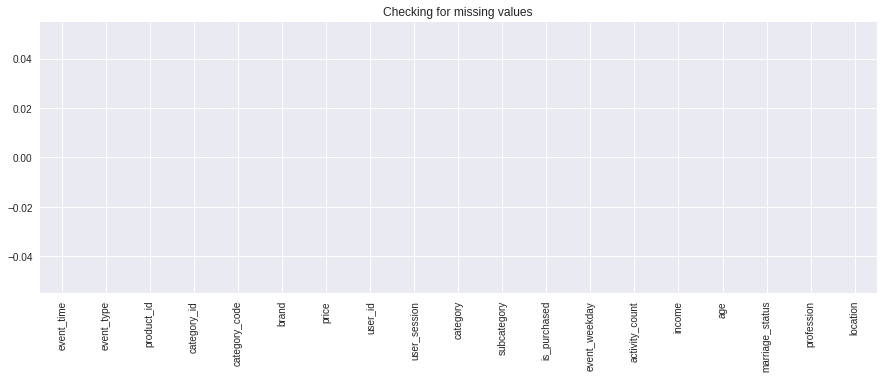

In [ ]:
data.isnull().sum().plot(kind = 'bar', figsize = (15, 5))
plt.title("Checking for missing values")
plt.show()

- There no missing values in the dataset

In [ ]:
visits = data['user_id'].nunique()
print(f"Total Number of Users is {visits}")

Total Number of Users is 32431


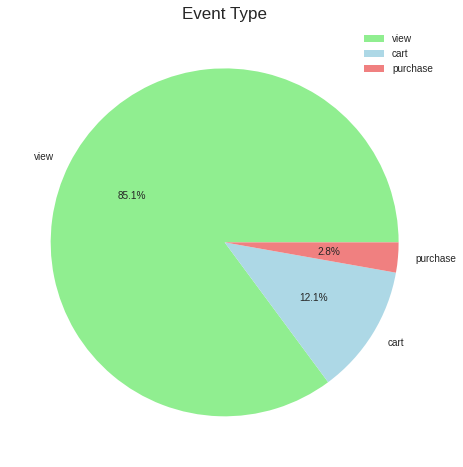

In [ ]:
plt.figure(figsize = (8, 8))
plt.pie(data['event_type'].value_counts(), colors = ['lightgreen', 'lightblue','lightcoral'], labels = ['view', 'cart','purchase'], autopct = '%.1f%%')
plt.title('Event Type', fontsize = 17)
plt.axis('off')
plt.legend()
plt.show()

- From the above chart, the highest event type is **View** which is always true in an e-commerce platform.

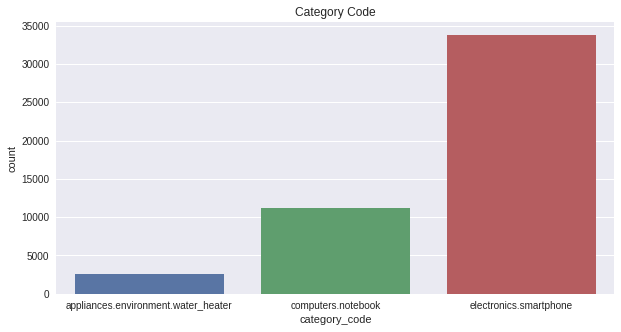

In [ ]:
plt.figure(figsize = (10, 5))
sns.countplot(data['category_code']).set_title("Category Code")
plt.show()

- we have three product category code of which the highest is electronic smartphone

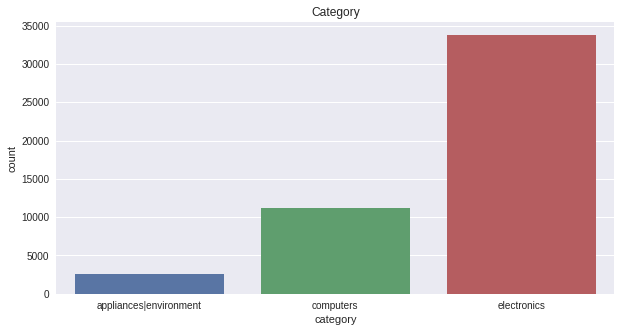

In [ ]:
plt.figure(figsize = (10, 5))
sns.countplot(data['category']).set_title("Category")
plt.show()

- The highest product category is electronics 

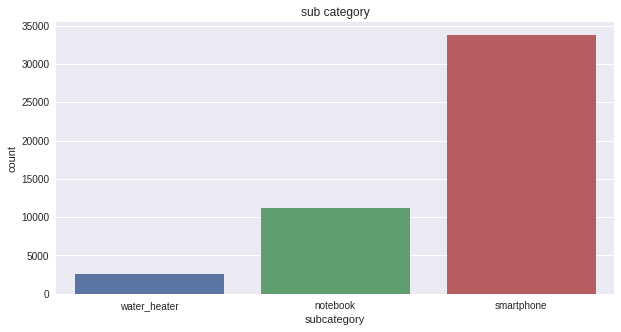

In [ ]:
plt.figure(figsize = (10, 5))
sns.countplot(data['subcategory']).set_title("sub category")
plt.show()

- The highest product subcategory is smartphone which is obvious as people tends to buy a smartphone than any other devics
- The three category columns are correlated so we can drop others and only use one for building the model.

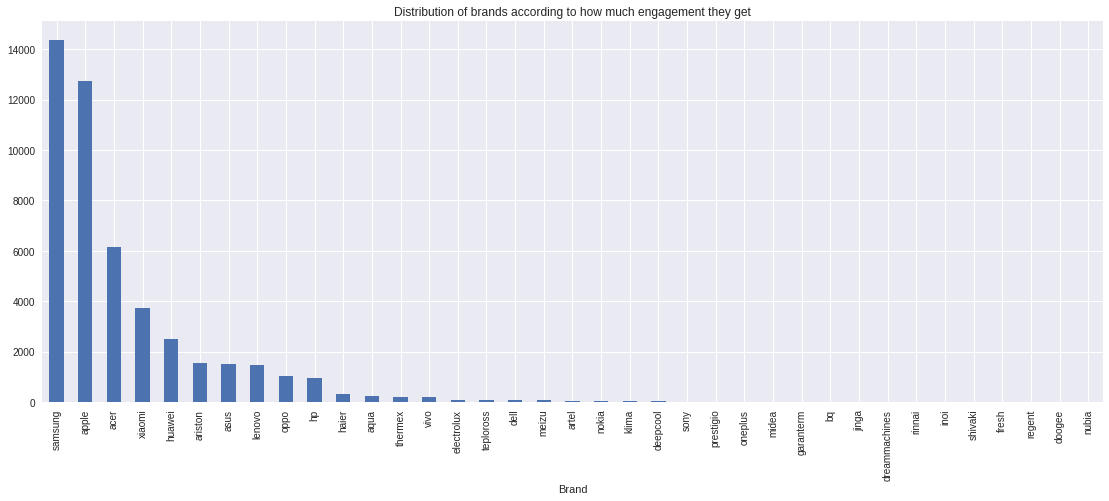

In [ ]:
data['brand'].value_counts().plot(kind = 'bar', title = 'Distribution of brands according to how much engagement they get',
                                  figsize = (19, 7))
plt.xlabel("Brand")
plt.show()

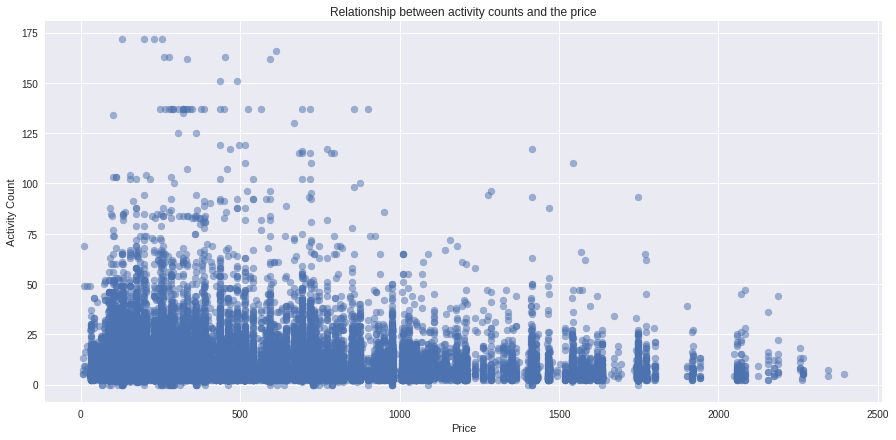

In [ ]:
plt.figure(figsize = (15, 7))
plt.scatter(data['price'], data['activity_count'], alpha = 0.5)
plt.title("Relationship between activity counts and the price")
plt.xlabel("Price")
plt.ylabel("Activity Count")
plt.show()

- There is somewhat negative relaionship between activity counts and price. Meaning as the activity counts falls the price might go up and vice versa 

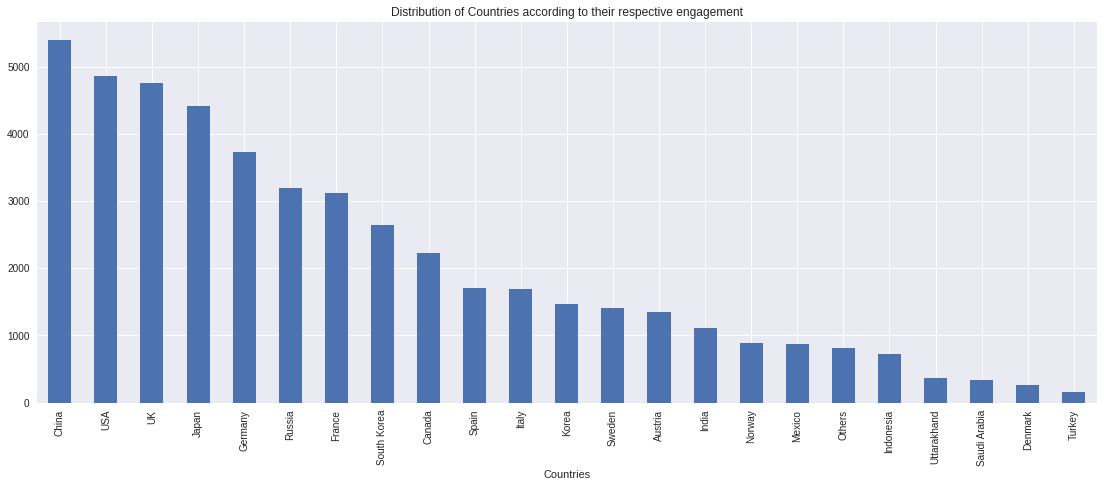

In [ ]:
data['country'].value_counts().plot(kind = 'bar', title = 'Distribution of Countries according to their respective engagement',
                                     figsize = (19, 7))
plt.xlabel("Countries")
plt.show()

- **China** is the location with the highest engagement which is true because china has the largest ecommerce market in the world.

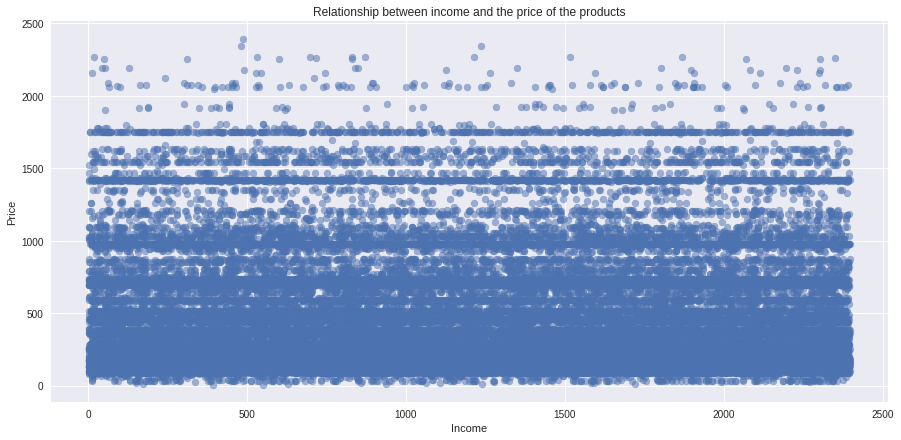

In [ ]:
plt.figure(figsize = (15, 7))
plt.scatter(data['income'], data['price'], alpha = 0.5)
plt.title("Relationship between income and the price of the products")
plt.xlabel("Income")
plt.ylabel("Price")
plt.show()

There is no noticeable relationship between the price and the income variable

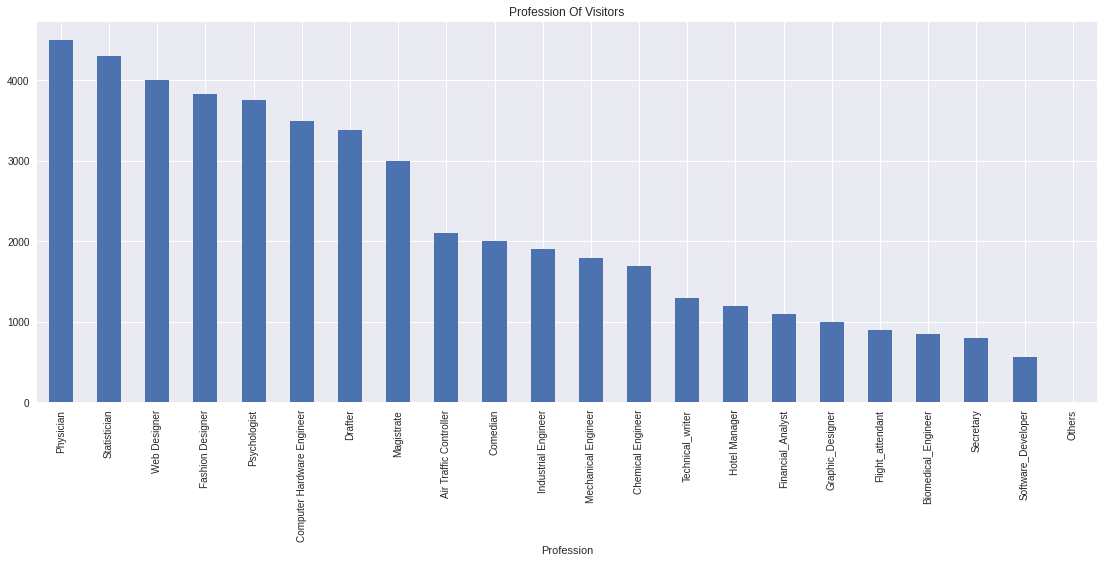

In [ ]:
data['profession'].value_counts().plot(kind = 'bar', title = 'Profession Of Visitors',
                                  figsize = (19, 7))
plt.xlabel("Profession")
plt.show()

- **Physician** is the profession that uses ecommerce platform most

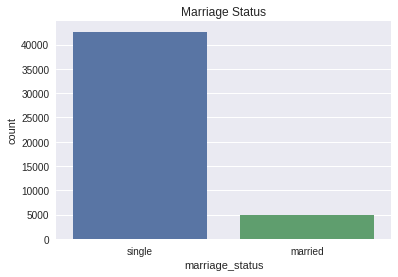

In [ ]:
sns.countplot(data['marriage_status']).set_title("Marriage Status")
plt.show()

- Only very few users are married

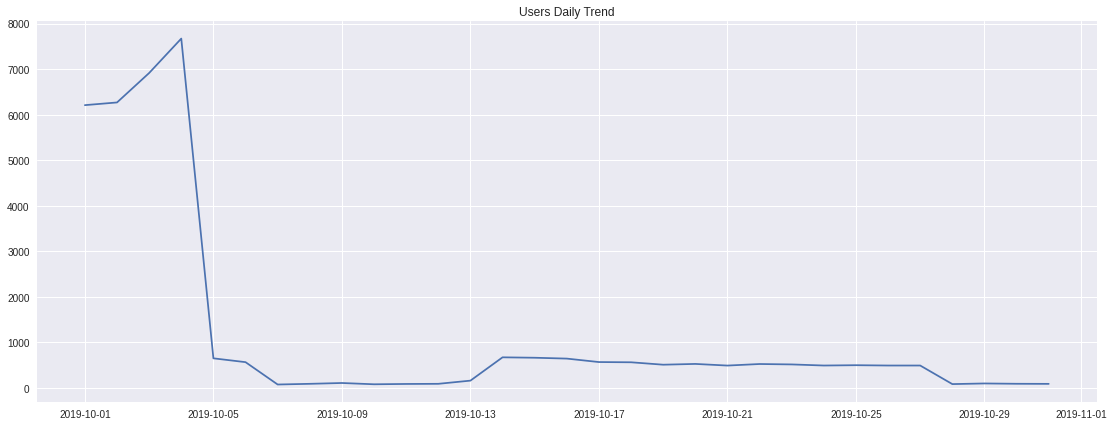

In [ ]:
plt.figure(figsize = (19, 7))
vdt = data.loc[:,['event_time','user_id']] # Selecting only the event_time and user_id columns
vdt['event_time'] = vdt['event_time'].apply(lambda s: str(s)[0:10])
visit_by_date = vdt.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visit_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visit_by_date['count']
plt.title("Users Daily Trend")
plt.plot(x,y)
plt.show()

The highest visits occur on 2019-10-05(Saturday) which could be as a result of weekend when little or no work is done by the people and also on 2019-10-01(Tuesday)

In [ ]:
buy = data[data['event_type'] == 'purchase'] #Items the custumers bought
cart = data[data['event_type'] == 'cart'] #Items that were carted

no_of_total_visitors = data['user_id'].nunique() #to get the no of those that visit the store
no_of_cart = cart['user_id'].nunique() # the number of people that cart product from the store

no_of_total_visitors = data['user_id'].nunique() #to get the no of those that visit the store
no_of_buy = buy['user_id'].nunique() # the number of people that buy from the store

print(f"1. Out of {no_of_total_visitors} that visited the store, {no_of_cart} products were carted\n")
print(f"2. Out of {no_of_total_visitors} that visited the store, only {no_of_buy} bought a product")

1. Out of 32431 that visited the store, 4524 products were carted

2. Out of 32431 that visited the store, only 1123 bought a product


In [ ]:
# Checking the brand that was bought most

buy['brand'].value_counts()[: 5]

samsung    334
apple      255
ariston    251
xiaomi     104
acer        73
Name: brand, dtype: int64

The product with the highest sale is Samsung

In [ ]:
# Checking the brand that was carted most

cart['brand'].value_counts()[: 5]

samsung    1556
apple      1439
acer        935
lenovo      390
xiaomi      381
Name: brand, dtype: int64

Samsung is also the product brand that was carted most

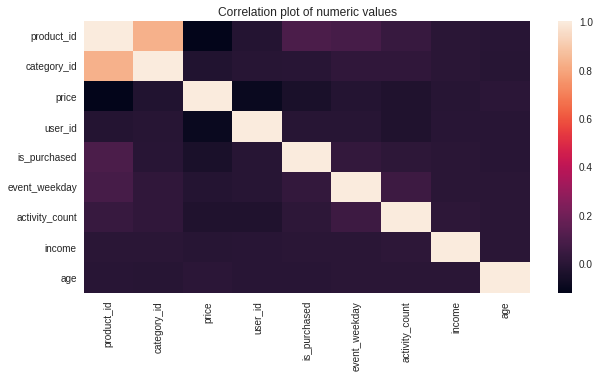

In [ ]:
plt.figure(figsize = (10, 5))
sns.heatmap(data.corr()).set_title("Correlation plot of numeric values")
plt.show()

The corelation between product id and category id is the highest, the two columns will be dropped as they won't give more information to the model

## Data Preprocessing
- The 'category', 'subcategory' and 'category_code' provides similar information hence, only one of them will be used for modelling.
- The event_type and is_purchased column also provides similar information, hence only the event_type column will be used for modelling.

In [ ]:
 #dropping the 'category_code' and 'subcategory'  and other irrelavant columns
data = data.drop(['category_code', 'subcategory', 'product_id', 'category_id', 'user_session', 'is_purchased'], axis = 1) 

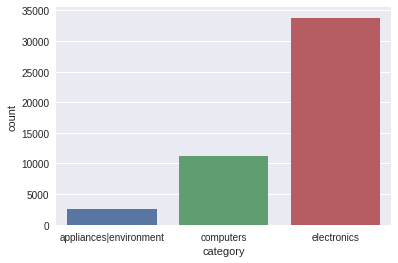

In [ ]:
sns.countplot(data['category'])

In [ ]:
data['category'].unique()

array(['appliances|environment', 'computers', 'electronics'], dtype=object)

- According to the subcategory and category_code column, it is evident that 
1. Electronics represent **smartphone** and
2. Computers represent **computers**

- The 'appliances|environment' value in the category column will be replaced with the most frequent **smartphone** and other values will be renamed accordingly

In [ ]:
#Renaming the values of the category column so that we have only computer and smartphone
data['category'] = data['category'].replace(['appliances|environment', 'electronics'], 'smartphone')

In [ ]:
data['category'].unique()

array(['smartphone', 'computers'], dtype=object)

- The values of the category column has been renamed accordingly

In [ ]:
data.head()

,event_time,event_type,brand,price,user_id,category,event_weekday,activity_count,income,age,marriage_status,profession,location
0,2019-10-01 03:36:06 UTC,purchase,ariston,84.69,514732891.0,smartphone,1.0,21.0,312.415297,23,single,Mechanical_engineer,Madhya_Pradesh
1,2019-10-01 04:07:44 UTC,purchase,ariston,133.82,515798665.0,smartphone,1.0,4.0,1814.950879,40,single,Software_Developer,Maharashtra
2,2019-10-01 04:43:16 UTC,purchase,thermex,115.75,518045212.0,smartphone,1.0,3.0,956.489912,66,married,Technical_writer,Kerala
3,2019-10-01 05:07:47 UTC,purchase,ariston,103.18,514008577.0,smartphone,1.0,16.0,1499.125653,41,single,Software_Developer,Odisha
4,2019-10-01 05:14:48 UTC,purchase,ariston,105.68,513400739.0,smartphone,1.0,10.0,1382.295251,47,single,Civil_servant,Tamil_Nadu


In [ ]:
#From the event_time column we are going to extract the month, day and year
data['event_time'] = data['event_time'].str.strip('UTC')
data['event_time'] = pd.to_datetime(data['event_time'], format = '%Y-%m-%d')
data['year'] = data['event_time'].dt.year
data['month'] = data['event_time'].dt.month_name()
data['day'] = data['event_time'].dt.day_name()

In [ ]:
data.head(3)

,event_time,event_type,brand,price,user_id,category,event_weekday,activity_count,income,age,marriage_status,profession,country,year,month,day
0,2019-10-01 03:36:06,purchase,ariston,84.69,514732891,smartphone,1,21.0,312.415297,23,single,Physician,South Korea,2019,October,Tuesday
1,2019-10-01 04:07:44,purchase,ariston,133.82,515798665,smartphone,1,4.0,1814.950879,40,single,Physician,USA,2019,October,Tuesday
2,2019-10-01 04:43:16,purchase,thermex,115.75,518045212,smartphone,1,3.0,956.489912,66,married,Physician,India,2019,October,Tuesday


- The new columns has been added and we can then drop the now redundant column event_time and event_weekday column which is a repetition  of the day column

In [ ]:
data = data.drop(['event_time', 'event_weekday'], axis = 1)

In [ ]:
data['month'].unique()

array(['October'], dtype=object)

- The whole event happened in october and hence the month column can be dropped as it won't give the model any information

In [ ]:
data = data.drop('month', axis =1) #dropping the month column

In [ ]:
data['day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

The **day** column contains all the days in the week

In [ ]:
data.head()

,event_type,brand,price,user_id,category,activity_count,income,age,marriage_status,profession,country,year,day
0,purchase,ariston,84.69,514732891,smartphone,21.0,312.415297,23,single,Physician,South Korea,2019,Tuesday
1,purchase,ariston,133.82,515798665,smartphone,4.0,1814.950879,40,single,Physician,USA,2019,Tuesday
2,purchase,thermex,115.75,518045212,smartphone,3.0,956.489912,66,married,Physician,India,2019,Tuesday
3,purchase,ariston,103.18,514008577,smartphone,16.0,1499.125653,41,single,Physician,Mexico,2019,Tuesday
4,purchase,ariston,105.68,513400739,smartphone,10.0,1382.295251,47,single,Physician,France,2019,Tuesday


In [ ]:
data['year'].unique()

array([2019])

In [ ]:
data = data.drop('year', axis =1) #dropping the year column

The whole event also happened in 2019 and hence the year column can be dropped as it won't give the model any information

### Further Analysis

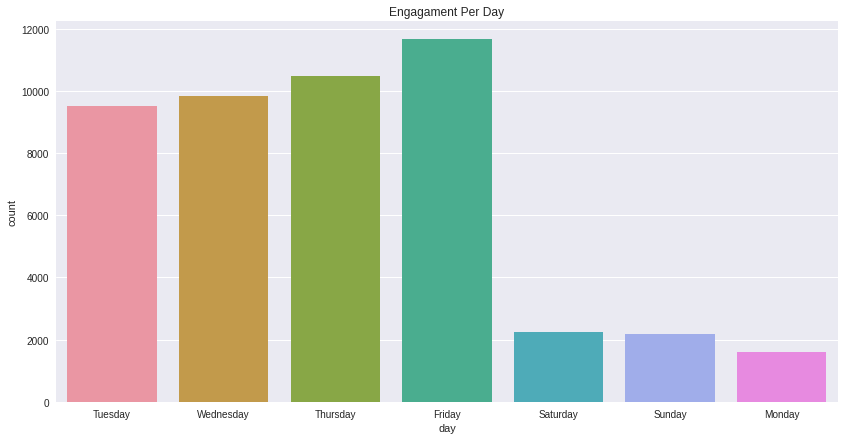

In [ ]:
plt.figure(figsize = (14, 7))
sns.countplot(data['day']).set_title("Engagament Per Day")
plt.show()

- The day with the highest engagement is Friday followed by Thursday and the least in Monday. This could be due to the fact that there is always much workload on mondays been the first workday of the week and hence, there will be less time for shopping.

In [ ]:
#Checking for the brand that has highest engagement on friday

data[data['day'] == 'Friday']['brand'].value_counts()[[0]]

samsung    3914
Name: brand, dtype: int64

- As expected, samsumg products has the highest engagement on friday

In [ ]:
#Checking for the product that was mostly bought on fridays been the day with highest engagement

bof = data[data['day'] == 'Friday']
pof = bof[bof['event_type'] == 'purchase']

pof['brand'].value_counts()[[0]]

samsung    150
Name: brand, dtype: int64

**Samsung** products is the highest products bought bought on friday 

In [ ]:
hac = data['activity_count'].max() #checking for the highest value in the activity_count column

print(f"The highest activity count is {hac}")

The highest activity count is 172.0


In [ ]:
#Check for the days when this high activity count occur

data[data['activity_count'] == 172.0]

,event_type,brand,price,user_id,category,activity_count,income,age,marriage_status,profession,country,day
15099,view,samsung,254.76,513322839,smartphone,172.0,1368.686682,21,single,Psychologist,China,Tuesday
15128,view,samsung,130.76,513322839,smartphone,172.0,966.090478,35,single,Psychologist,UK,Tuesday
32071,view,samsung,230.64,513322839,smartphone,172.0,1644.154167,42,single,Air Traffic Controller,UK,Thursday
32079,view,samsung,198.20,513322839,smartphone,172.0,2315.516845,71,single,Air Traffic Controller,France,Thursday


- High activity happen on **Tuesday** and **Thursday**,
- Event_type **view** meaning the customers only view alot of **samsung**(brand is samsung) products on **Tuesday** and **Thursday**
- Marriage Status **Single** 
-Profession of those visitors are **Psychologist** and **Air Traffic Controller**
- Countries: **China**, **France	** and **UK** 

In [ ]:
#Location with the highest purchases

print(f"The country with the highest purchases is {str(data[data['event_type'] == 'purchase']['country'].value_counts()[[0]]).split()[0]}\n")
print(f"The country with the highest carts is {str(data[data['event_type'] == 'cart']['country'].value_counts()[[0]]).split()[0]}\n")
print(f"Age {str(data[data['event_type'] == 'purchase']['age'].value_counts().iloc[[0]]).split()[0]} is the age that buys more products\n")
print(f"Age {str(data[data['event_type'] == 'cart']['age'].value_counts().iloc[[0]]).split()[0]} is the age that Carts more products\n")
print(f"The Profession with the highest purchases is {str(data[data['event_type'] == 'purchase']['profession'].value_counts()[[0]]).split()[0]}\n")
print(f"The Profession with the highest carts is {str(data[data['event_type'] == 'cart']['profession'].value_counts()[[0]]).split()[0]}\n")

The country with the highest purchases is China

The country with the highest carts is China

Age 72 is the age that buys more products

Age 68 is the age that Carts more products

The Profession with the highest purchases is Physician

The Profession with the highest carts is Magistrate



### Further preprocessing

In [ ]:
data['brand'].unique()

array(['ariston', 'thermex', 'artel', 'aqua', 'shivaki', 'garanterm',
       'klima', 'midea', 'haier', 'rinnai', 'electrolux', 'teploross',
       'regent', 'fresh', 'acer', 'apple', 'lenovo', 'asus', 'hp',
       'deepcool', 'dell', 'xiaomi', 'dreammachines', 'samsung', 'huawei',
       'meizu', 'nokia', 'oppo', 'vivo', 'sony', 'jinga', 'oneplus',
       'prestigio', 'inoi', 'bq', 'doogee', 'nubia'], dtype=object)

In [ ]:
data['brand'].value_counts()

samsung          14387
apple            12753
acer              6145
xiaomi            3736
huawei            2492
ariston           1537
asus              1502
lenovo            1483
oppo              1049
hp                 947
haier              302
aqua               238
thermex            188
vivo               184
electrolux          84
teploross           76
dell                75
meizu               60
artel               55
nokia               52
klima               29
deepcool            23
sony                15
prestigio           15
oneplus             12
midea               10
garanterm           10
bq                   5
jinga                4
dreammachines        3
rinnai               3
inoi                 2
shivaki              2
fresh                1
regent               1
doogee               1
nubia                1
Name: brand, dtype: int64

To get a better prediction, we are only going to work with the top brands with highest engagement and replace the other brands with others since they are small and negligible. 





In [ ]:
data['brand'].value_counts()[:5]

samsung    14387
apple      12752
acer        6145
xiaomi      3736
huawei      2492
Name: brand, dtype: int64

In [ ]:
fet_col = ['samsung', 'apple', 'acer', 'xiaomi', 'huawei']
for i in data['brand']:
  if i not in fet_col:
    data['brand'] = data['brand'].replace(i, 'others')

In [ ]:
data['brand'].unique()

array(['others', 'acer', 'apple', 'xiaomi', 'samsung', 'huawei'],
      dtype=object)

#### Undersampling the dataset

We will undersample the dataset to avoid imbalance of the classes which can lead to the model bias(Predicting only one/certain class(es))


In [ ]:
#Undersampling the data 
samsung_set = data[data['brand'] == 'samsung']
others_set = data[data['brand'] == 'others']
apple_set = data[data['brand'] == 'apple']
acer_set = data[data['brand'] == 'acer']
xiaomi_set = data[data['brand'] == 'xiaomi']
huawei_set = data[data['brand'] == 'huawei']

samsung_set_downsampled = samsung_set.sample(2000)
others_set_downsampled = others_set.sample(2000)
apple_set_downsampled = apple_set.sample(2000)
acer_set_downsampled = acer_set.sample(2000)
xiaomi_set_downsampled = xiaomi_set.sample(2000)
huawei_set_downsampled = huawei_set.sample(2000)

ddata = pd.concat([samsung_set_downsampled, others_set_downsampled, apple_set_downsampled, acer_set_downsampled, xiaomi_set_downsampled, huawei_set_downsampled])

ddata['brand'].value_counts()

samsung    2000
others     2000
apple      2000
acer       2000
xiaomi     2000
huawei     2000
Name: brand, dtype: int64

- The dataset has been downsampled to contain equal number of each classes
- It will also reduced the size of the machine learning model with makes it easy for further computation(deployment).


In [ ]:
ddata.shape

(12000, 12)

In [ ]:
tdata = ddata.copy()

In [ ]:
#Converting categorical values to integer
event = {'view': 0, 'cart': 1, 'purchase': 2}
tdata['event_type'] = tdata['event_type'].map(event)

brand = {'others': 5, 'acer': 3, 'apple': 4, 'xiaomi': 1, 'samsung': 0, 'huawei': 2}
tdata['brand'] = tdata['brand'].map(brand)

cat = {'smartphone': 1, 'computers': 0}
tdata['category'] = tdata['category'].map(cat)

marriage = {'married': 1, 'single': 0}
tdata['marriage_status'] = tdata['marriage_status'].map(marriage)

pro = {'Physician':0, 'Statistician':1, 'Graphic_Designer':2, 'Web Designer':3,
       'Psychologist':4, 'Others':5, 'Computer Hardware Engineer':6,
       'Software_Developer':7, 'Drafter':8, 'Magistrate':9, 'Fashion Designer':10,
       'Biomedical_Engineer':11, 'Air Traffic Controller':12, 'Comedian':13,
       'Industrial Engineer':14, 'Mechanical Engineer':15, 'Chemical Engineer':16,
       'Technical_writer':17, 'Hotel Manager':18, 'Secretary':19,
       'Financial_Analyst':20, 'Flight_attendant':21}
tdata['profession'] = tdata['profession'].map(pro)

country = {'China':0, 'Germany':1, 'Italy':2, 'Sweden':3, 'Canada':4, 'Mexico':5, 'Japan':6,
       'USA':7, 'France':8, 'Spain':9, 'Russia':10, 'Denmark':11, 'UK':12, 'Norway':13,
       'India':14, 'Uttarakhand':15, 'Korea':16, 'Austria':17, 'South Korea':18,
       'Others':19, 'Saudi Arabia':20, 'Indonesia':21, 'Turkey':22}
tdata['country'] = tdata['country'].map(country)

day = {'Tuesday':3, 'Thursday':5, 'Friday':6, 'Wednesday':4, 'Saturday':0, 'Monday':2,'Sunday':1}
tdata['day'] = tdata['day'].map(day)

In [ ]:
tdata.isnull().sum()

event_type         0
brand              0
price              0
user_id            0
category           0
activity_count     0
income             0
age                0
marriage_status    0
profession         0
country            0
day                0
dtype: int64

The data is now ready for training

In [ ]:
# Selecting the dependent and independent variable

x = tdata.drop('brand', axis = 1) #independent variables
y = tdata['brand'] #dependent variable

## Modelling Building and Evaluation



In [ ]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42) 

#### Random Forest Classifier
Random forest Classifier is a Supervised Machine Learning Algorithm that builds decision trees on different samples and takes their majority vote for classification and average in case of regression. They are mostly used for predicting binary classes but also performs greatly on multiclass prediction.

In [ ]:
#Modelling with random forest algorithm
rf = RandomForestClassifier()
rf.fit(x_train.values, y_train)

RandomForestClassifier()

#### Decision Tree Classifier
The Decision Tree Classifier creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute. They are mostly used for predicting binary classes but also performs greatly on multiclass prediction just like the Random Forest Classifier.

In [ ]:
#Modelling with random forest algorithm
dtree = DecisionTreeClassifier()
dtree.fit(x_train.values, y_train)

DecisionTreeClassifier()

#### Logistic regression
Logistic regression is an example of supervised learning. It is used to calculate or predict the probability of a binary (yes/no) event occurring. Though it can be used to predict multiple classes, it only works best on binary classification.

In [ ]:
#Modelling with random forest algorithm
lr = LogisticRegression()
lr.fit(x_train.values, y_train)

LogisticRegression()

#### Gaussian NB
Naïve Bayes is a probabilistic machine learning algorithm used for many classification functions and is based on the Bayes theorem. Gaussian Naïve Bayes is the extension of naïve Bayes. it also performes poorly on multiple class prediction but not as logidtics regression.

In [ ]:
#Modelling with random forest algorithm
nb = GaussianNB()
nb.fit(x_train.values, y_train)

GaussianNB()

In [ ]:
#Writing a function to evaluate the performance of the models
def evaluate(model):
  y_pred = model.predict(x_test)
  print(f"The accuracy score of the {type(model).__name__} is {round(accuracy_score(y_test, y_pred) * 100)}%\n")
  print(f"The Precision score of the {type(model).__name__} is {round(precision_score(y_test, y_pred, average='macro') * 100)}%\n")
  print(f"The Recall score of the {type(model).__name__} is {round(recall_score(y_test, y_pred, average='macro') * 100)}%\n")
  print(f"The F1 score of the {type(model).__name__} is {round(f1_score(y_test, y_pred, average='macro') * 100)}%\n\n")
  plot_confusion_matrix(model, x_test, y_test)
  plt.xlabel("Predicted Label")
  plt.title("Confusion Matrix")
  plt.show()

The accuracy score of the RandomForestClassifier is 84%

The Precision score of the RandomForestClassifier is 84%

The Recall score of the RandomForestClassifier is 84%

The F1 score of the RandomForestClassifier is 83%




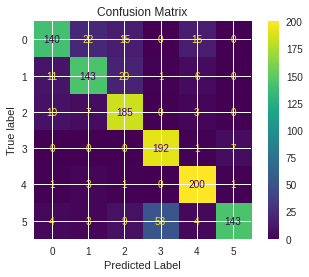

In [ ]:
evaluate(rf)

The accuracy score of the DecisionTreeClassifier is 95%

The Precision score of the DecisionTreeClassifier is 95%

The Recall score of the DecisionTreeClassifier is 96%

The F1 score of the DecisionTreeClassifier is 95%




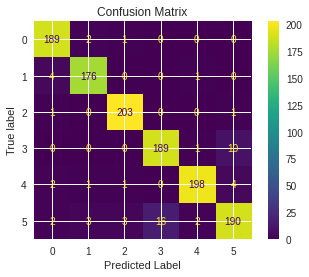

In [ ]:
evaluate(dtree)

The accuracy score of the GaussianNB is 30%

The Precision score of the GaussianNB is 38%

The Recall score of the GaussianNB is 31%

The F1 score of the GaussianNB is 27%




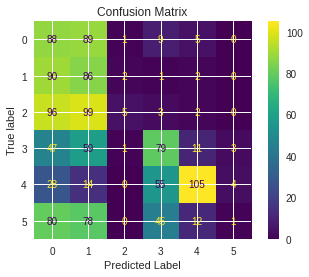

In [ ]:
evaluate(nb)

The accuracy score of the LogisticRegression is 15%

The Precision score of the LogisticRegression is 3%

The Recall score of the LogisticRegression is 17%

The F1 score of the LogisticRegression is 4%




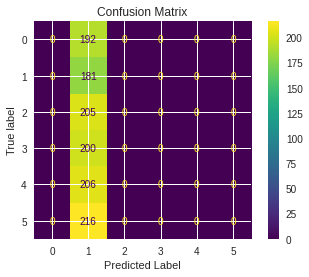

In [ ]:
evaluate(lr)

- The Accuracy Score is the number(percentage) of correct predictions over all predictions. It is the base metric used for model evaluation often 

- Precision Score is a measure / percentage of how many of the positive predictions made are correct

- Recall score is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made

- F1 score is sums up the predictive performance of a model by combining precision and recall. It is a very important metric for the evaluation of machine learning models.

As described above, Logistic Regression and Gaussion NB performed poorly with Logistic Regression predicting only class **1** according to the confusion matrix.

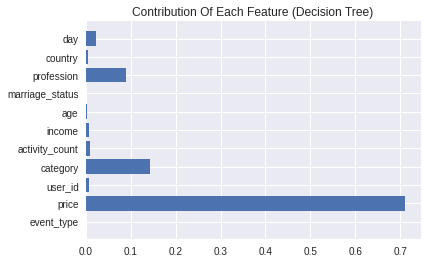

In [ ]:
plt.barh(x.columns, dtree.feature_importances_)
plt.title("Contribution Of Each Feature (Decision Tree)")
plt.show()

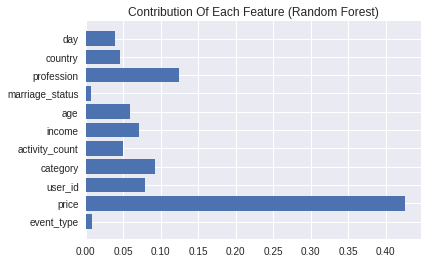

In [ ]:
plt.barh(x.columns, rf.feature_importances_)
plt.title("Contribution Of Each Feature (Random Forest)")
plt.show()

From the two charts above, The decision tree classifier which was the best model greatly depends on the price feature and didn't consider some of the features, hence, we will use the Random Forest model which took all features to consideration and less dependant on one price column like the decision tree model for deployment.

Generally, The price of a product is the most important feature anyone would consider before purchasing a product which is also obvious in both charts.

In [ ]:
#Saving/exporting the model
dump(rf, "model.joblib")

['model.joblib']


------
------